In [8]:
import numpyro
numpyro.set_host_device_count(5)

import numpy as np

import jax.numpy as jnp
from jax import random
import numpyro.distributions as dist
from numpyro import factor, plate, sample
from numpyro.infer import MCMC, NUTS, init_to_median
import numpy as np
from jax import numpy as jnp

import joblib

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import candel

In [3]:
data = joblib.load("/Users/rstiskalek/Downloads/data.joblib")
SPEED_OF_LIGHT = 299_792.458  # km / s

In [17]:
np.exp(-15), jnp.log(200)

(3.059023205018258e-07, Array(5.2983174, dtype=float32, weak_type=True))

In [21]:
data["e_czcmb_cepheid_host"]

array([ 5.99584916, 14.9896229 ,  5.99584916,  5.99584916, 44.9688687 ,
       44.9688687 ,  2.99792458,  2.99792458,  5.99584916, 44.9688687 ,
        2.99792458, 17.98754748,  5.99584916,  0.        ,  2.99792458,
        5.99584916,  2.99792458,  5.99584916,  2.99792458,  5.99584916,
        5.99584916,  2.99792458,  5.99584916, 44.9688687 , 56.96056702,
        2.99792458, 44.9688687 , 44.9688687 , 44.9688687 , 17.98754748,
       35.97509496, 44.9688687 ,  5.99584916,  2.99792458,  5.99584916])

In [13]:
jnp.log(1e-8), jnp.log(200)

(Array(-18.420681, dtype=float32, weak_type=True),
 Array(5.2983174, dtype=float32, weak_type=True))

In [4]:
def r2mu(r):
    return 5 * jnp.log10(r) + 25

def r2cz(r, H0):
    return r * H0

def mu2r(mu):
    return 10**((mu - 25) / 5)

def drdmu(mu):
    return 1 / 5 * np.log(10) * 10**((mu - 25) / 5)

r2mu_candel = candel.Distance2Distmod()
r2z_candel = candel.Distance2Redshift()
mu2r_candel = candel.Distmod2Distance()
log_drdmu_candel = candel.LogGrad_Distmod2ComovingDistance()



def model(num_hosts, num_cepheids, mag_cepheid, e_mag_cepheid, logP, OH,
          L_Cepheid_host_dist, cz_host, e_cz_host, mag_SN, e_mag_SN,
          mu_N4258_anchor, e_mu_N4258_anchor,
          mu_LMC_anchor, e_mu_LMC_anchor, version, sample_dZP):
    # Sample model parameters.
    H0 = sample("H0", dist.Uniform(10, 100))
    h = H0 / 100

    M_W = sample("M_W", dist.Uniform(-7, -5))
    b_W = sample("b_W", dist.Uniform(-4, -2))
    Z_W = sample("Z_W", dist.Uniform(-1, 1))

    M_B = sample("M_B", dist.Uniform(-20, -18))
    
    if sample_dZP:
        dZP = sample("dZP", dist.Normal(0, 0.1))
    else:
        dZP = 0

    sigma_v = sample("sigma_v", dist.Uniform(5, 1000))

    # MW calibration
    sample("M_W_Combined", dist.Normal(M_W, 0.0239), obs=-5.8946)

    if version == "eleni":
        with plate("plate_host", num_hosts + 3):
            # u = sample("u", dist.Uniform(1e-9, 1))
            logr = sample("logr_host", dist.Uniform(jnp.log(1e-8), jnp.log(200)))
            factor("lp_r2", 3 * logr)
        # r_host_all = 200 * u**(1/3)

        r_host_all = jnp.exp(logr)
        z_cos_all = H0 * r_host_all / SPEED_OF_LIGHT
        DL = r_host_all * (1 + z_cos_all)
        mu_host_all = 5 * jnp.log10(DL) + 25

        cz_pred = H0 * r_host_all[:-3]
    elif version == "distmod_approx":
        with plate("plate_host", num_hosts + 3):
            mu_host_all = sample("mu_host", dist.Uniform(10, 43))
        r_host_all = 10**((mu_host_all - 25) / 5)
        factor("lp_r2", 3 * jnp.log(r_host_all))

        cz_pred = H0 * r_host_all[:-3]
    elif version == "distmod_exact":
        with plate("plate_host", num_hosts + 3):
            mu_host_all = sample("mu_host", dist.Uniform(10, 43))
            
        r_host_all = mu2r_candel(mu_host_all, h)
        factor(
            "lp_r2",
            2 * jnp.log(r_host_all) + log_drdmu_candel(mu_host_all, h=h))
        cz_pred = r2z_candel(r_host_all[:-3], h=h) * SPEED_OF_LIGHT
    else:
        raise ValueError("Unknown version")

    mu_N4258 = mu_host_all[-3]
    mu_LMC = mu_host_all[-2]

    # Distance calibration
    sample("ll_N4258", dist.Normal(mu_N4258, e_mu_N4258_anchor), obs=mu_N4258_anchor)
    sample("ll_LMC", dist.Normal(mu_LMC, e_mu_LMC_anchor), obs=mu_LMC_anchor)

    mu_host_all_for_cepheid = jnp.copy(mu_host_all)
    mu_host_all_for_cepheid = mu_host_all_for_cepheid.at[-2].add(dZP)

    mu_cepheid = L_Cepheid_host_dist @ mu_host_all_for_cepheid
    pred_mag_cepheid = mu_cepheid + M_W + b_W * logP + Z_W * OH

    # with plate("plate_test_cepheid", num_cepheids):
    #     M = sample("M", dist.Normal(M_W + b_W * logP + Z_W * OH, 0.1))
    # pred_mag_cepheid = mu_cepheid + M

    with plate("plate_ll_Cepheid", num_cepheids):
        sample("ll_cepheid",
               dist.Normal(pred_mag_cepheid, e_mag_cepheid),
               obs=mag_cepheid)

    mu_host = mu_host_all[:-3]

    with plate("plate_ll_host", num_hosts):
        sample(
            "ll_host",
            dist.Normal(cz_pred, jnp.sqrt(e_cz_host**2 + sigma_v**2)),
            obs=cz_host)

    mag_SN_pred = M_B + mu_host
    with plate("plate_ll_SN", num_hosts):
        sample(
            "ll_SN",
            dist.Normal(mag_SN_pred, e_mag_SN),
            obs=mag_SN)

    logS = -1.38 * M_B
    factor("logS", - num_hosts * logS)

In [5]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=200))
mcmc = MCMC(kernel, num_warmup=500, num_samples=10000, num_chains=5, progress_bar=True)
mcmc.run(
    random.PRNGKey(41),
    num_hosts=data["num_hosts"],
    num_cepheids=data["num_cepheids"],
    mag_cepheid=jnp.asarray(data["mag_cepheid"]),
    e_mag_cepheid=jnp.sqrt(jnp.diag(data["C_Cepheid"])),
    logP=jnp.asarray(data["logP"]),
    OH=jnp.asarray(data["OH"]),
    cz_host=jnp.asarray(data["czcmb_cepheid_host"]),
    e_cz_host=jnp.asarray(data["e_czcmb_cepheid_host"]),
    L_Cepheid_host_dist=jnp.asarray(data["L_Cepheid_host_dist"]),
    mag_SN=jnp.asarray(data["mag_SN_unique_Cepheid_host"]),
    e_mag_SN=jnp.sqrt(jnp.diag(data["C_SN_unique_Cepheid_host"])),
    mu_N4258_anchor=data["mu_N4258_anchor"],
    e_mu_N4258_anchor=data["e_mu_N4258_anchor"],
    mu_LMC_anchor=data["mu_LMC_anchor"],
    e_mu_LMC_anchor=data["e_mu_LMC_anchor"],
    version="eleni",
    # version="distmod_approx"
    # version="distmod_exact"
    sample_dZP=False,
)

mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           H0     68.18      1.89     68.18     64.98     71.18  39487.04      1.00
          M_B    -19.30      0.03    -19.30    -19.34    -19.25  17217.26      1.00
          M_W     -5.90      0.02     -5.90     -5.93     -5.88  16319.52      1.00
          Z_W     -0.17      0.03     -0.17     -0.22     -0.13  76573.12      1.00
          b_W     -3.29      0.01     -3.29     -3.31     -3.26  41725.29      1.00
 logr_host[0]      1.93      0.01      1.93      1.91      1.95  24086.38      1.00
 logr_host[1]      3.66      0.04      3.66      3.60      3.72  57132.46      1.00
 logr_host[2]      3.61      0.03      3.61      3.55      3.67  60046.88      1.00
 logr_host[3]      3.48      0.03      3.48      3.44      3.53  57975.43      1.00
 logr_host[4]      3.47      0.02      3.47      3.43      3.50  40283.64      1.00
 logr_host[5]      2.92      0.02      2.92      2.88      2.95  47235.39  

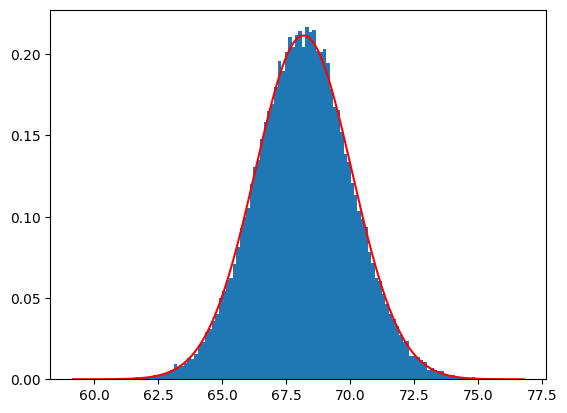

In [12]:
from scipy.stats import norm

plt.figure()
plt.hist(samples["H0"], bins="auto", density=1)

x = np.linspace(samples["H0"].min(), samples["H0"].max(), 2000)
plt.plot(x, norm.pdf(x, samples["H0"].mean(), samples["H0"].std()), c="red")

plt.show()